In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import pmdarima as pm
from pmdarima.arima import auto_arima
import re
from statsmodels.tsa.stattools import adfuller


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#from pandas_datareader import data as pdr
import datetime as dt

import yfinance as yf

In [3]:
#legacy code from LSTM to retrieve prices
class price_volume_data:
    """A class for retrieving and analyzing price and volume data."""
    def __init__(self, tickers, start_date, end_date):
        """
        Initializes a new instance of the price_volume_data class.

        Args:
            tickers (list): A list of tickers for the assets to retrieve data for.
            start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
            end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.pv = self.__retrieve_data__()
        #self.lp, self.ret = self.__get_daily_returns__() #didn't need daily returns
        
    def __retrieve_data__(self):
        """
        Retrieves price and volume data for the given tickers from Yahoo Finance API.

        Returns:
            dict: A dictionary containing the price and volume data for each ticker.
        """

        data, failed = {}, []
        for ticker in self.tickers:
            try:
                df = yf.Ticker(ticker).history(start = self.start_date, end = self.end_date)
                
                data[ticker] = df
                
            except:
                failed.append(ticker)
                
        if failed:
            print('Tickers failed to extract: ', failed)
        
        return data
    
    def __get_daily_returns__(self):
        """
        Computes daily returns for the retrieved price data.

        Returns:
            pd.DataFrame: A DataFrame containing the daily price data.
            pd.DataFrame: A DataFrame containing the daily price returns.
        """
        df = pd.DataFrame()
        
        for ticker in self.pv:
            if df.empty:
                df = pd.DataFrame(self.pv[ticker]['Close'].copy())
            else:
                df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)

        df.columns = self.tickers
        df = df.fillna(method = 'ffill')
        
        return df, df/df.shift(1) - 1
    
    def get_info(self, ticker = None):
        """
        Prints information about the price and volume data for the specified ticker.
        If no ticker is provided, prints information for all tickers.

        Args:
            ticker (str, optional): The ticker symbol for the asset. Defaults to None.
        """
        if ticker:
            self.pv[ticker].info()
        
        else:
            for ticker in self.pv:
                self.pv[ticker].info()
                
        return None
    
    def plot_price_trends(self, normalize = True, reference = -1):
        """
        Plots the close prices of selected assets over time.

        Args:
            normalize (bool, optional): Indicates whether to normalize the prices. Defaults to True.
            reference (int, optional): Reference point for normalization. Defaults to -1.
        """
        f, ax = plt.subplots(1,1,figsize=(12,5))
        # plot prices
        for key in self.pv:
            last_price = self.pv[key].loc[:, 'Close'].copy()
            if normalize:
                if reference == -1:
                    last_price /= last_price.iloc[0]
                elif reference == 0:
                    midpt = int(last_price.shape[0]/2)
                    last_price /= last_price.iloc[midpt]
                else:
                    last_price /= last_price.iloc[-1]
            last_price.plot(ax = ax, label = key)
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def plot_corr(self, method='pearson', output = False, series = 'price'):
        """
        Plots the correlation matrix between asset prices or returns.

        Args:
            method (str, optional): The correlation method to use. Defaults to 'pearson'.
            output (bool, optional): Indicates whether to return the correlation matrix. Defaults to False.
            series (str, optional): Indicates whether to use 'price' or 'returns'. Defaults to 'price'.

        Returns:
            pd.DataFrame or None: The correlation matrix if output=True, None otherwise.
        """
        corr_matrix = self.lp.corr(method) if series == 'price' else self.ret.corr(method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        f, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
        
        return corr_matrix if output else None
        
        
    def get_technical_indicators(self, indicators = None, normalize = True):
        """
        Computes and adds various technical indicators to the price data.

        Args:
            indicators (list, optional): A list of tuples specifying the indicators and their parameters.
                Defaults to None.
            normalize (bool, optional): Indicates whether to normalize the indicator values. Defaults to True.
        """
        if not indicators:
            indicators = [('SMA', 5), ('SMA', 14), ('ATR', 5), ('ATR', 14), ('ADX', 5),
                         ('ADX', 14), ('RSI', 5), ('RSI', 14), ('MACD', None), ('BBANDS', None)]
        
        for data in self.pv:
            df = self.pv[data]
            for indicator, param in indicators:
                
                if indicator == 'SMA':
                    df[f'{indicator}_{param}'] = talib.SMA(df['Close'], param)

                elif indicator == 'ATR':
                    df[f'{indicator}_{param}'] = talib.ATR(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'ADX':
                    df[f'{indicator}_{param}'] = talib.ADX(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'RSI':
                    df[f'{indicator}_{param}'] = talib.RSI(df['Close'], param) 
                    
                elif indicator == 'MACD':
                    df[f'{indicator}'], df[f'{indicator}_signal'], _ = talib.MACD(df['Close']) 
                    
                    
                elif indicator == 'BBANDS':
                    df[f'{indicator}_upp'], df[f'{indicator}_mid'], df[f'{indicator}_low'] = talib.BBANDS(df['Close'])
                    
                    
                else:
                    print('Indicators not built into the class. Please run TALIB manually!')
            
            df = df.replace([np.inf, -np.inf], np.nan, inplace = True)
            
        return None              

In [4]:
sheet_name = ['20220526','20220825','20221124','20230223','20230525']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[0]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']
# symbols = symbols[symbols['Ticker_Symbol']!='TW/.L']
# symbols = symbols[symbols['Ticker_Symbol']!='MDC.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HL/.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

0      ICP.L
1     ABDN.L
2     SMDS.L
4       HL.L
5      DPH.L
6      HIK.L
7     HWDN.L
8      IDS.L
9      ITV.L
10     CCL.L
11    INVP.L
12     CNA.L
13    CTEC.L
14     UTG.L
15    JMAT.L
16    WEIR.L
18    BBOX.L
19     EZJ.L
20     IMI.L
21     DLN.L
22     TUI.L
23     SXS.L
24     HSX.L
25     DLG.L
26     EMG.L
27    DPLM.L
28     IGG.L
29    WIZZ.L
30    FRAS.L
31    TATE.L
32     BEZ.L
33     PNN.L
34     RSW.L
Name: Ticker_Symbol, dtype: object

In [5]:
symbols_ = symbols.set_index("Ticker_Symbol")

In [6]:
data = price_volume_data(symbols_short.to_list(),'2017-05-27', '2022-05-31')
data.pv

{'ICP.L':                                   Open         High          Low        Close  \
 Date                                                                            
 2017-05-30 00:00:00+01:00   687.080036   694.442992   681.267177   682.429749   
 2017-05-31 00:00:00+01:00   681.654654   687.855037   680.492082   683.979797   
 2017-06-01 00:00:00+01:00   685.917335   694.055337   679.716952   686.692383   
 2017-06-02 00:00:00+01:00   688.242571   690.955238   678.554471   681.654663   
 2017-06-05 00:00:00+01:00   681.654768   683.716375   672.741715   676.229431   
 ...                                ...          ...          ...          ...   
 2022-05-24 00:00:00+01:00  1312.555141  1337.080392  1308.921770  1323.909424   
 2022-05-25 00:00:00+01:00  1344.347116  1344.347116  1307.105067  1324.817749   
 2022-05-26 00:00:00+01:00  1379.318323  1451.531565  1372.051582  1425.643799   
 2022-05-27 00:00:00+01:00  1419.285366  1457.889927  1417.014509  1449.714844   
 2022-0

In [7]:
#data wrangling
#objective is to have a dataframe of close prices. columns = stocks and rows = price observations (time series)

df = data.pv[symbols_short[0]]["Close"]
for stock in symbols_short[1:]:
    
    df = pd.concat([df, data.pv[stock]["Close"]], axis = 1)

df.columns = symbols_short
df.index = pd.to_datetime(df.index.date)

In [8]:
df

Ticker_Symbol,ICP.L,ABDN.L,SMDS.L,HL.L,DPH.L,HIK.L,HWDN.L,IDS.L,ITV.L,CCL.L,...,DLG.L,EMG.L,DPLM.L,IGG.L,WIZZ.L,FRAS.L,TATE.L,BEZ.L,PNN.L,RSW.L
2017-05-30,682.429749,274.629944,311.732697,1233.008423,1760.797241,1470.324341,389.829590,313.057495,141.296692,4432.711426,...,237.057709,112.054794,1008.373840,346.428711,2343.0,299.000000,588.729736,420.354462,801.381531,3419.916260
2017-05-31,683.979797,273.131592,312.877747,1233.891113,1812.064697,1481.735596,386.756012,315.343597,139.023438,4442.544922,...,237.193756,111.912506,1007.473694,365.518280,2279.0,297.700012,589.528564,421.962921,792.348206,3426.395020
2017-06-01,686.692383,274.772675,315.811798,1240.951904,1771.983032,1498.414062,391.366302,315.272156,136.110840,4500.645508,...,236.309235,112.552818,1010.174622,366.144104,2280.0,295.000000,589.129150,421.337433,788.476746,3477.300293
2017-06-02,681.654663,273.702423,314.094330,1249.777954,1821.385986,1474.713379,387.268280,313.700439,135.968765,4590.033691,...,235.832947,112.766273,1011.975159,367.395874,2279.0,292.899994,593.522766,421.784180,781.164185,3469.895996
2017-06-05,676.229431,271.205170,312.877747,1225.947754,1789.693726,1470.324341,386.670654,314.343445,133.766556,4514.054688,...,235.356674,111.129906,1008.373840,366.144104,2307.0,295.000000,601.910217,417.494904,781.164185,3437.501465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-24,1323.909424,167.978851,271.082397,791.668152,3416.174561,1624.289185,623.591675,299.203094,64.549553,872.000000,...,241.485413,225.025497,2417.815186,639.604492,2976.0,634.000000,729.711487,467.812714,984.604126,3860.357666
2022-05-25,1324.817749,167.802094,271.897583,788.804626,3431.908203,1611.314209,635.875488,299.203094,65.754044,884.400024,...,244.091370,230.489075,2456.812012,644.102478,3069.0,639.000000,740.266113,462.334351,955.039062,3732.920898
2022-05-26,1425.643799,173.149475,275.792175,815.912659,3492.876221,1637.744873,646.047974,312.174591,67.049789,965.599976,...,247.179932,238.267746,2491.138672,649.499939,3034.0,672.000000,733.069763,468.204010,924.578186,3821.146240
2022-05-27,1449.714844,173.370422,279.958496,813.240051,3549.910645,1622.847412,648.543030,306.165741,64.458313,986.400024,...,250.944077,238.730759,2524.484619,652.198730,2993.0,689.500000,724.434143,476.617218,905.764099,3844.673096


In [9]:
file = pd.read_csv("prediction_result_3days_200622.csv")
file = file.set_index("Unnamed: 0")

In [10]:
file

,Actual Price,Predicted Price,MSE,MAE,R2,Market Share,final_marketcap
Unnamed: 0,,,,,,,
CCL.L,1011.500000,[1102.1017],0.004354,0.065982,1,146260000,"147,941,990,000.00"
PNN.L,921.890503,[978.6994],0.094318,0.307112,1,261327008,240914886834.23047
IGG.L,652.198731,[628.6662],0.035130,0.187431,1,395398016,257878084065.0625
ITV.L,65.962585,[66.964294],0.002242,0.047346,1,4034409984,266120113306.78125
INVP.L,433.472778,[401.9024],0.167294,0.409016,1,645161984,"279,660,157,671.13"
EMG.L,240.397629,[223.5084],0.285668,0.534479,1,1199859968,288443491180.2617
TATE.L,722.515076,[747.0776],0.113386,0.336728,1,401665984,290209728829.28516
RSW.L,4005.439697,[3899.5273],0.019304,0.138940,1,72788496,291549931382.66016
IDS.L,313.700653,[276.65097],0.108747,0.329769,1,956193024,299958376095.6797


In [11]:
########################################

In [12]:
df_standardised = df.iloc[:-3].apply(lambda price: (price.iloc[:-3] - price.iloc[:-3].mean())/price.iloc[:-3].std())
df_standardised




Ticker_Symbol,ICP.L,ABDN.L,SMDS.L,HL.L,DPH.L,HIK.L,HWDN.L,IDS.L,ITV.L,CCL.L,...,DLG.L,EMG.L,DPLM.L,IGG.L,WIZZ.L,FRAS.L,TATE.L,BEZ.L,PNN.L,RSW.L
2017-05-30,-1.254231,1.129804,-0.217801,-1.157580,-1.313952,-0.611237,-1.002289,0.108076,1.993221,1.176858,...,-0.743056,-0.760581,-1.107556,-1.640107,-1.691022,-0.811428,-0.498227,-0.283145,-0.383614,-1.296951
2017-05-31,-1.250504,1.095116,-0.194177,-1.154032,-1.256512,-0.587082,-1.021898,0.128702,1.884744,1.183950,...,-0.735153,-0.765129,-1.108884,-1.491656,-1.775771,-0.820433,-0.487219,-0.262530,-0.432780,-1.288548
2017-06-01,-1.243982,1.133108,-0.133644,-1.125654,-1.301419,-0.551779,-0.992485,0.128057,1.745758,1.225849,...,-0.786533,-0.744664,-1.104899,-1.486790,-1.774447,-0.839137,-0.492723,-0.270547,-0.453852,-1.222523
2017-06-02,-1.256095,1.108331,-0.169078,-1.090182,-1.246068,-0.601947,-1.018629,0.113877,1.738978,1.290313,...,-0.814200,-0.737842,-1.102242,-1.477055,-1.775771,-0.853685,-0.432174,-0.264821,-0.493652,-1.232127
2017-06-05,-1.269140,1.050517,-0.194177,-1.185957,-1.281576,-0.611237,-1.022442,0.119678,1.633891,1.235520,...,-0.841865,-0.790141,-1.107556,-1.486790,-1.738693,-0.839137,-0.316585,-0.319794,-0.493652,-1.274143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,0.255476,-1.374051,-0.953693,-2.764089,0.331400,-0.242612,0.675210,0.165511,-1.669939,-1.252522,...,-0.491466,2.811568,0.937370,0.618795,-0.884582,1.876391,1.689294,0.202228,0.486844,-0.804527
2022-05-17,0.333014,-1.298340,-0.837839,-2.650537,0.368859,-0.211079,0.672761,0.242098,-1.579369,-1.240984,...,-0.199931,2.817487,0.905727,0.681756,-0.699194,1.886782,1.755409,0.342655,0.511225,-0.730784
2022-05-18,0.231450,-1.396560,-1.067678,-2.701942,0.309365,-0.308731,0.529494,0.230051,-1.680389,-1.260455,...,-0.323272,2.737576,0.888466,0.618795,-0.729651,1.817509,1.451275,0.430421,0.516101,-0.779098
2022-05-19,0.075283,-1.567420,-1.172321,-2.870736,0.459203,-0.257871,0.502554,-0.134815,-1.730028,-1.294349,...,-0.491466,2.468246,0.856822,0.576821,-0.740244,1.689352,1.173588,0.264919,0.423453,-0.875727


In [13]:
actual_price_ls = []
ticker_mean_dict = {}
ticker_std_dict = {}
for column in df.columns:
    ticker_mean_dict[column] = df[column].iloc[:-3].mean()
    ticker_std_dict[column] = df[column].iloc[:-3].std()
    actual_price_ls.append((df[column].iloc[-1] - ticker_mean_dict[column]) / ticker_std_dict[column])
actual_price_df = pd.DataFrame(index = df.columns)
actual_price_df["actual_price"] = actual_price_ls


In [14]:
#FINAL

"""
ARIMA & NAIVE


#inputs = df, dataframe of close prices.
#outputs = dataframe of (params_dict). contains the optimized params (p, d, q) using auto-arima
        # = plots of original time series
        # = plots of results.summary() of fitting optimized params into ARIMA(p,d,q)
        # = plots of residuals
        # = plots of forecast (3 days look-ahead) 
"""


import re
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima.arima import auto_arima

def find_differencing_order(ts, look_forward):
    d = 0
                                                    
    p_value = adfuller(ts.iloc[:-(look_forward)].dropna())[1]
    while p_value > 0.05:  # Adjust the significance level as needed
        ts_interm = ts.diff().dropna()
        d += 1
        p_value = adfuller(ts_interm)[1]
    return d




####creating a function for ARIMA prediction

def get_ARIMA_PRED(standardised_df, look_forward):
    dict_ = {}
    models = {}  
    results = {}
    
    for column in standardised_df.columns:

        differencing_order = find_differencing_order(standardised_df[column], look_forward)

        best_model = auto_arima(standardised_df[column].iloc[:-(look_forward)].dropna(), start_p=0, d=differencing_order, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=True, trace=True,
                                stepwise=True, suppress_warnings=True, error_action='ignore')



        p_optimal = best_model.get_params()['order'][0]
        d_optimal = best_model.get_params()['order'][1]
        q_optimal = best_model.get_params()['order'][2]

        model_name = re.sub(r'\W+', '_', f'{column}').lower()
        models[model_name] = sm.tsa.ARIMA(standardised_df[column].iloc[:-(look_forward)].dropna(), order=(p_optimal, d_optimal, q_optimal))
        results[model_name] = models[model_name].fit()

        # Print model summary
        print(results[model_name].summary())

        # Plot the residuals to check for randomness
        # Residuals should show no predictability in variance and have a mean of 0
        residuals = results[model_name].resid
        plt.figure(figsize=(12, 6))
        plt.plot(residuals)
        plt.title('Residuals')
        plt.xlabel('Date')
        plt.ylabel('Residual Value')
        plt.show()

        # Forecast future values
        forecast_steps = look_forward  # Number of time steps to forecast ahead
        forecast = results[model_name].forecast(steps=forecast_steps)

        dict_[column] = {
            "optimal_p": p_optimal,
            "optimal_q": q_optimal,
            "optimal_d": d_optimal,
            "ARIMA_prediction": forecast.iloc[look_forward-1],  # because forecast is a Series with indexing that starts from 0, therefore we subtract 1
        }

    # Create a DataFrame to store the model information
    dict_df = pd.DataFrame(dict_)
    
    return dict_df


#import the price data for the remaining target universe at different rank dates

#dictionary to store DataFrames
dfs_target_uni = {}
params_dict_ = {}

# Loop through each sheet name and read the corresponding sheet into a DataFrame
for date in sheet_name:
    dfs_target_uni[f'df_{sheet_name}'] = pd.read_excel("target_stock_universe.xlsx", sheet_name=date)
    
    params_dict_[date] = get_ARIMA_PRED(df_standardised, 3)
    

sheet_name = ['20220524','20220823','20221122','20230221','20230523']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[0]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3089.044, Time=3.69 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3087.048, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3087.044, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3090.642, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3085.902, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.377 seconds
                               SARIMAX Results                                
Dep. Variable:                  ICP.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1546.321
Date:                Mon, 30 Oct 2023   AIC                          -3090.642
Time:                        15:23:48   BIC                          -3085.507
Sample:                             0   HQIC                         -3088.712
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


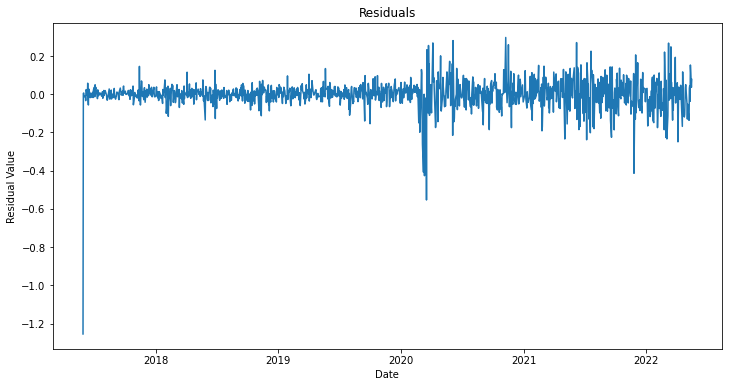

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2183.848, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2182.740, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2182.720, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2185.391, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2179.888, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.825 seconds
                               SARIMAX Results                                
Dep. Variable:                 ABDN.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1093.695
Date:                Mon, 30 Oct 2023   AIC                          -2185.391
Time:                        15:23:50   BIC                          -2180.255
Sample:                             0   HQIC                         -2183.460
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


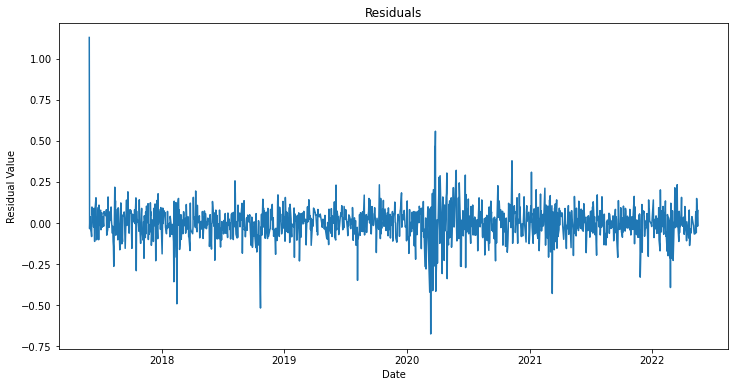

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1649.665, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1649.077, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1649.132, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1651.646, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1648.726, Time=0.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.955 seconds
                               SARIMAX Results                                
Dep. Variable:                 SMDS.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 826.823
Date:                Mon, 30 Oct 2023   AIC                          -1651.646
Time:                        15:23:52   BIC                          -1646.510
Sample:                             0   HQIC                         -1649.715
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


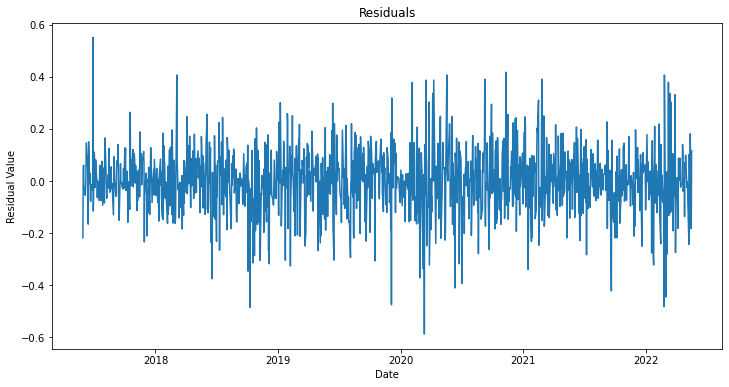

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1563.374, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1561.701, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1561.713, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1565.269, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1559.748, Time=0.53 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.519 seconds
                               SARIMAX Results                                
Dep. Variable:                   HL.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 783.634
Date:                Mon, 30 Oct 2023   AIC                          -1565.269
Time:                        15:23:53   BIC                          -1560.133
Sample:                             0   HQIC                         -1563.339
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


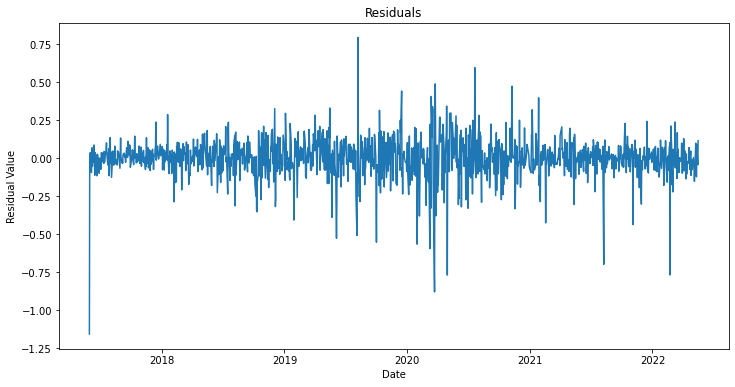

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3348.551, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3349.697, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3349.665, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3349.980, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3347.713, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.893 seconds
                               SARIMAX Results                                
Dep. Variable:                  DPH.L   No. Observations:                 1248
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1675.990
Date:                Mon, 30 Oct 2023   AIC                          -3349.980
Time:                        15:23:55   BIC                          -3344.852
Sample:                             0   HQIC                         -3348.052
                               - 1248                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


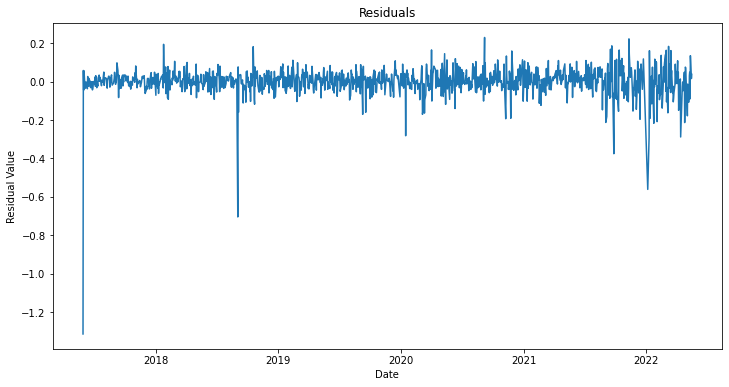

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2921.328, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2921.236, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2921.335, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2923.306, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2920.581, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.019 seconds
                               SARIMAX Results                                
Dep. Variable:                  HIK.L   No. Observations:                 1256
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1462.653
Date:                Mon, 30 Oct 2023   AIC                          -2923.306
Time:                        15:23:56   BIC                          -2918.171
Sample:                             0   HQIC                         -2921.376
                               - 1256                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


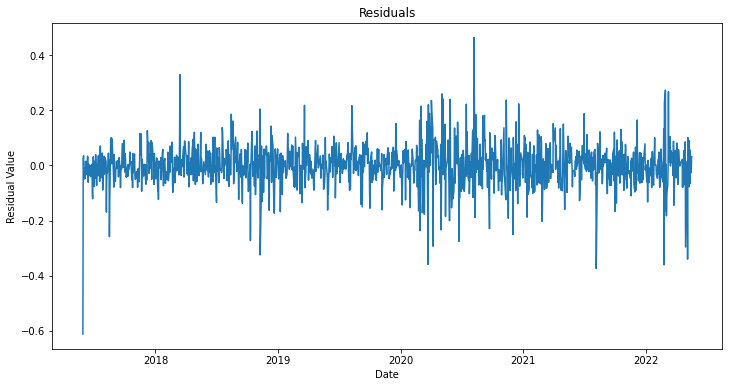

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3341.021, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3341.791, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3341.588, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3342.474, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3340.499, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.877 seconds
                               SARIMAX Results                                
Dep. Variable:                 HWDN.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1672.237
Date:                Mon, 30 Oct 2023   AIC                          -3342.474
Time:                        15:23:57   BIC                          -3337.339
Sample:                             0   HQIC                         -3340.544
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


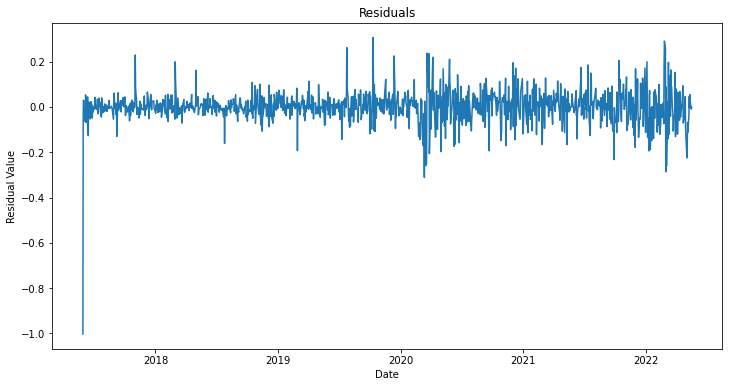

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3496.394, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3496.589, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3496.344, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3498.390, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3499.250, Time=0.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3499.175, Time=0.94 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3498.821, Time=0.90 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3499.147, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3499.326, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3497.569, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3495.595, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3501.323, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3498.585, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-3499.565, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  IDS.L   No. Observations:                 1257
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1753.661
Date:                Mon, 30 Oct 2023   AIC                          -3501.323
Time:                        15:24:03   BIC                          -3485.916
Sample:                             0   HQIC                         -3495.532
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0392      0.018      2.166      0.030       0.004       0.075
ar.L2          0.0614      0.026      2.338      0.019       0.010       0.113
sigma2         0.0036   5.34e-05     67.233      0.0

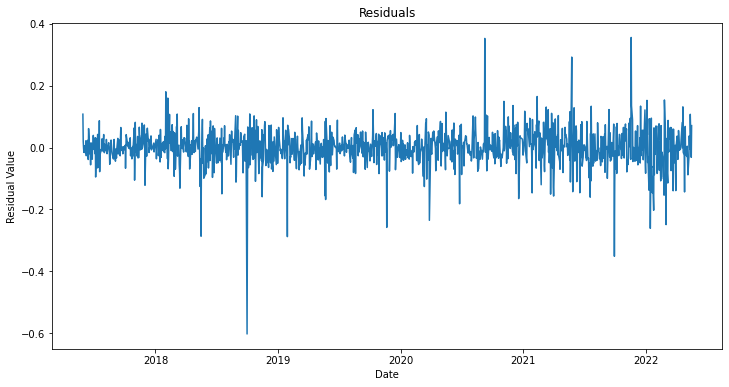

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2094.158, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2092.158, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2092.158, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2095.236, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2090.177, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.283 seconds
                               SARIMAX Results                                
Dep. Variable:                  ITV.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1048.618
Date:                Mon, 30 Oct 2023   AIC                          -2095.236
Time:                        15:24:05   BIC                          -2090.100
Sample:                             0   HQIC                         -2093.305
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


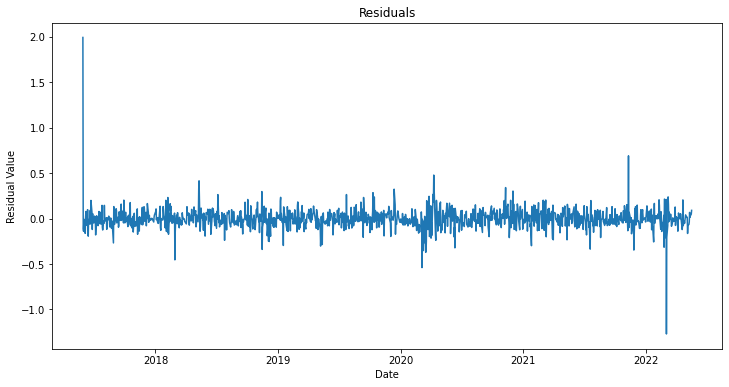

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4174.599, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4176.255, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4176.013, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4174.387, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4175.816, Time=0.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4175.921, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4173.963, Time=1.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4176.274, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4175.976, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4176.215, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4176.008, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4174.278, Time=0.21 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.672 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


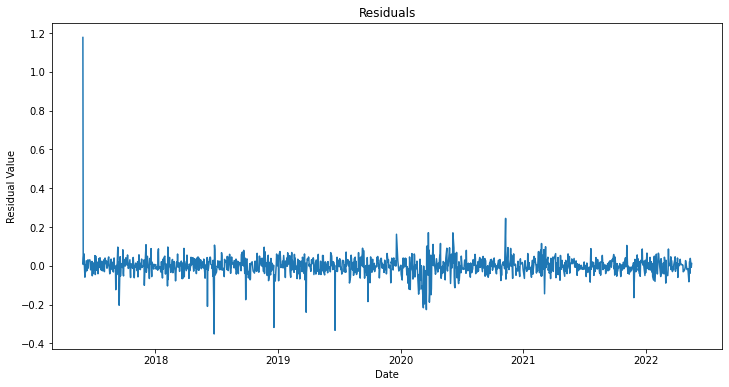

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2936.775, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2934.928, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2934.908, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2938.534, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2939.665, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2941.650, Time=0.79 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2940.552, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2940.348, Time=1.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2939.711, Time=1.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2941.489, Time=0.73 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2941.362, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2938.119, Time=1.44 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2943.483, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2941.504, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


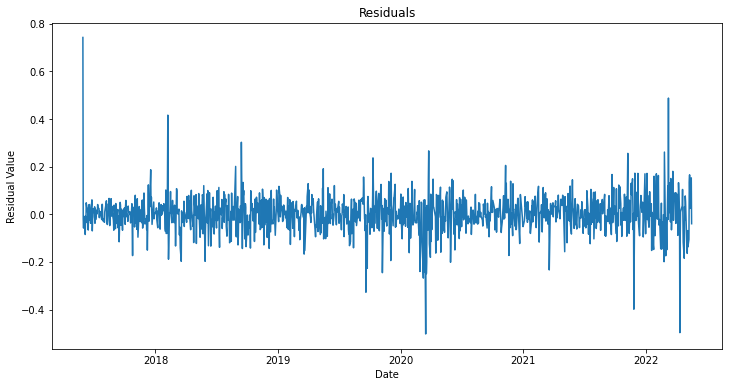

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3758.272, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3756.317, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3756.319, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3759.253, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3754.650, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.808 seconds
                               SARIMAX Results                                
Dep. Variable:                  CNA.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1880.626
Date:                Mon, 30 Oct 2023   AIC                          -3759.253
Time:                        15:24:21   BIC                          -3754.117
Sample:                             0   HQIC                         -3757.322
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


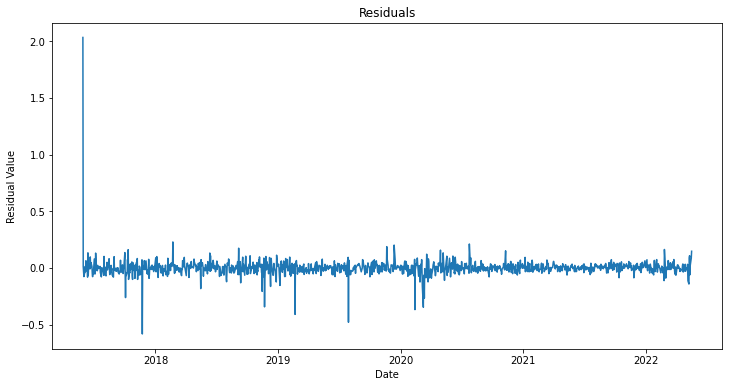

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3571.040, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2041.404, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3569.045, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1734.744, Time=0.54 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1733.923, Time=1.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1733.664, Time=0.69 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=995.194, Time=0.64 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1731.600, Time=0.85 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1736.198, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2039.405, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1735.1

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 CTEC.L   No. Observations:                 1257
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 871.372
Date:                Mon, 30 Oct 2023   AIC                          -1734.744
Time:                        15:24:31   BIC                          -1714.198
Sample:                             0   HQIC                         -1727.022
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4237      0.536      0.790      0.430      -0.628       1.475
ar.L1          0.9949      0.003    364.040      0.000       0.990       1.000
ma.L1         -0.0240      0.026     -0.928      0.3

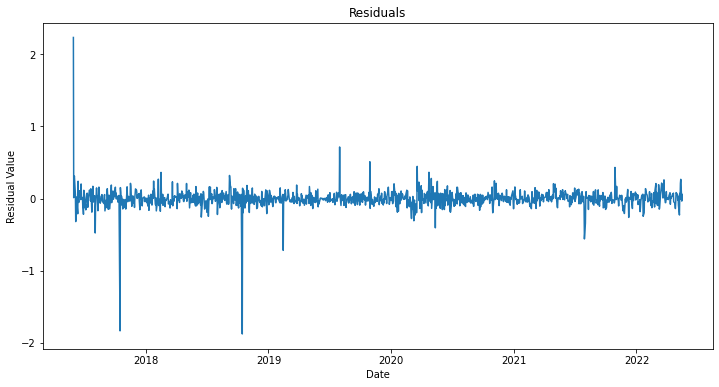

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2473.327, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2488.055, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2486.865, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2474.533, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2487.042, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2486.615, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2485.755, Time=0.74 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2489.423, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2488.444, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2488.003, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2488.207, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2487.154, Time=0.62 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.665 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


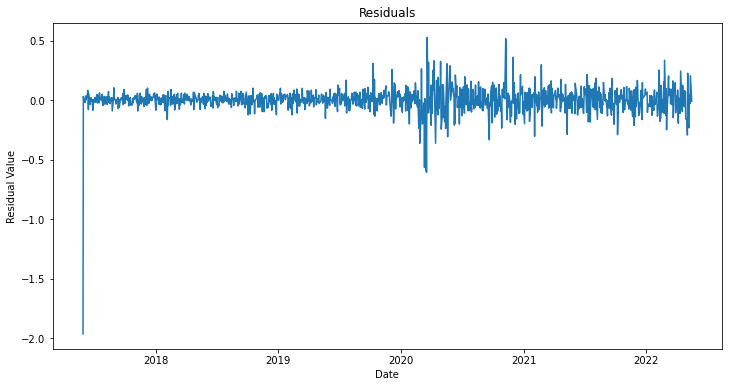

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1688.719, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1686.962, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1686.972, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1690.670, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1685.724, Time=0.78 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.617 seconds
                               SARIMAX Results                                
Dep. Variable:                 JMAT.L   No. Observations:                 1253
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 846.335
Date:                Mon, 30 Oct 2023   AIC                          -1690.670
Time:                        15:24:36   BIC                          -1685.537
Sample:                             0   HQIC                         -1688.740
                               - 1253                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


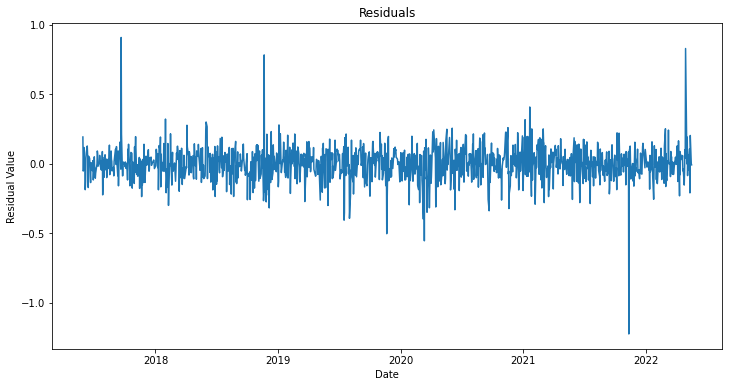

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1704.562, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1702.562, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1702.562, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1706.548, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1700.574, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.929 seconds
                               SARIMAX Results                                
Dep. Variable:                 WEIR.L   No. Observations:                 1256
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 854.274
Date:                Mon, 30 Oct 2023   AIC                          -1706.548
Time:                        15:24:37   BIC                          -1701.413
Sample:                             0   HQIC                         -1704.618
                               - 1256                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


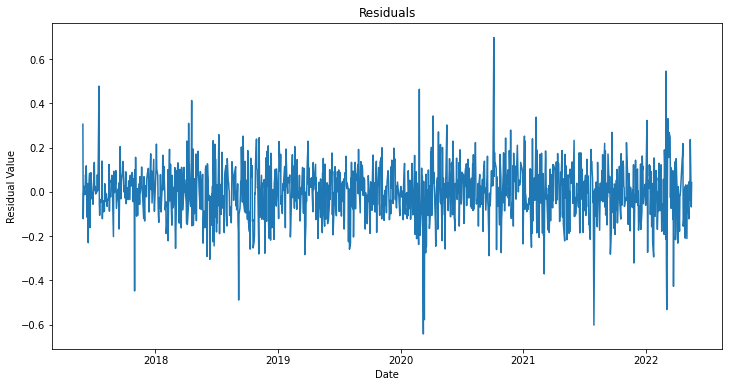

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3762.662, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3765.756, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3765.375, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3763.384, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3765.586, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3764.892, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3763.662, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3766.630, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3766.542, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3765.814, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3766.221, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3764.601, Time=0.20 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.843 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


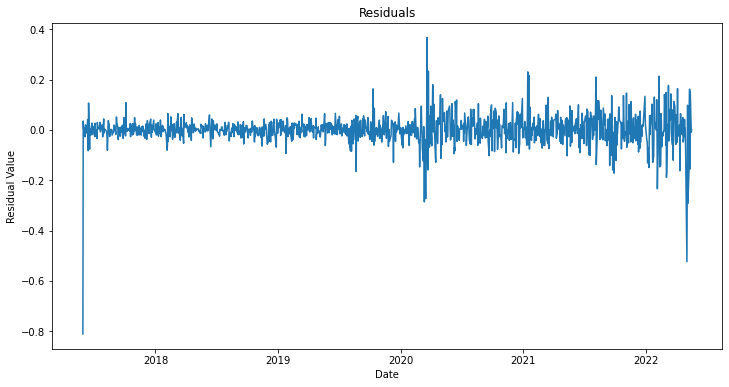

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2543.614, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2544.618, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2544.332, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2545.032, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2544.381, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.998 seconds
                               SARIMAX Results                                
Dep. Variable:                  EZJ.L   No. Observations:                 1256
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1273.516
Date:                Mon, 30 Oct 2023   AIC                          -2545.032
Time:                        15:24:42   BIC                          -2539.897
Sample:                             0   HQIC                         -2543.102
                               - 1256                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


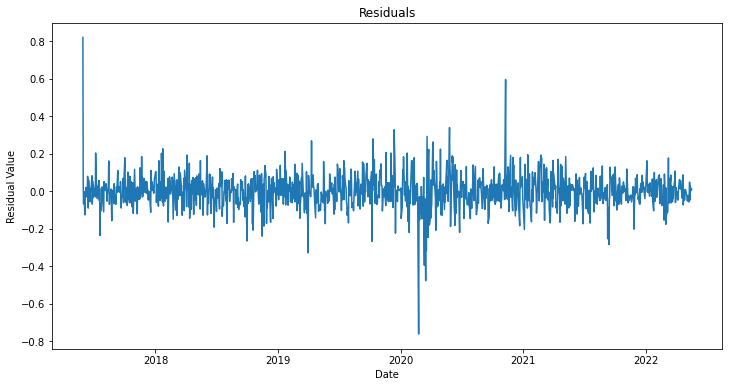

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3130.466, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3128.475, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3128.475, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3132.312, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3126.484, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.764 seconds
                               SARIMAX Results                                
Dep. Variable:                  IMI.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1567.156
Date:                Mon, 30 Oct 2023   AIC                          -3132.312
Time:                        15:24:43   BIC                          -3127.176
Sample:                             0   HQIC                         -3130.381
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


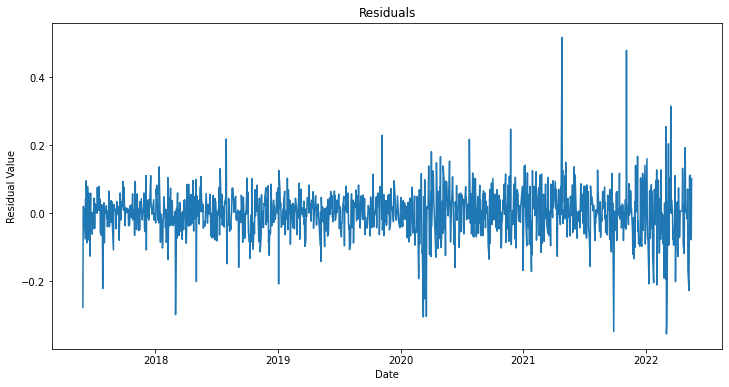

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1560.992, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1558.993, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1558.993, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1562.887, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1558.120, Time=0.49 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.979 seconds
                               SARIMAX Results                                
Dep. Variable:                  DLN.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 782.443
Date:                Mon, 30 Oct 2023   AIC                          -1562.887
Time:                        15:24:44   BIC                          -1557.751
Sample:                             0   HQIC                         -1560.956
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


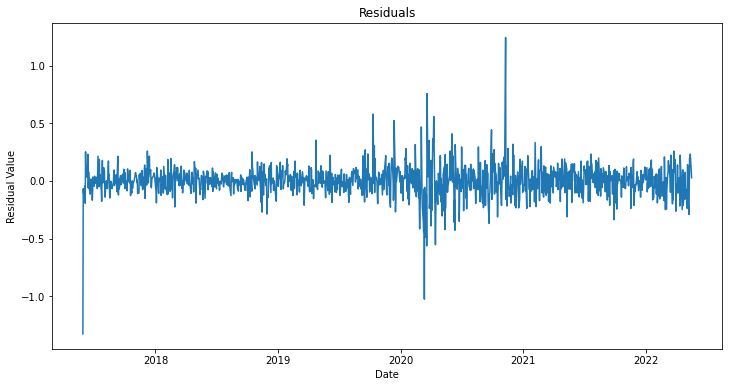

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4229.407, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4231.280, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4231.361, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4230.021, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4229.533, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4229.472, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4227.463, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4232.120, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4230.263, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4230.207, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4232.044, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4228.199, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.612 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


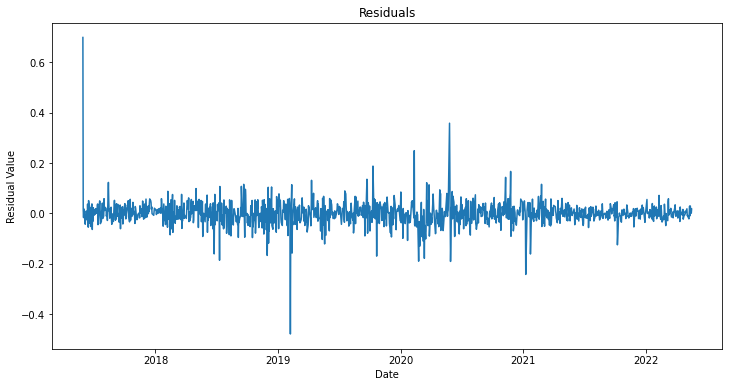

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2619.414, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2625.015, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2624.545, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2621.163, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2624.126, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2623.850, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2622.183, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2626.725, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2625.852, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2625.540, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2626.255, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2623.914, Time=0.21 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.439 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


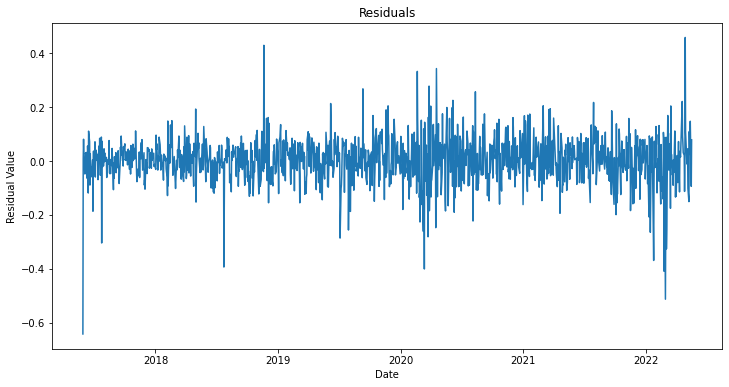

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2874.795, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2874.055, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2874.221, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2876.771, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2874.678, Time=0.56 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.058 seconds
                               SARIMAX Results                                
Dep. Variable:                  HSX.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1439.386
Date:                Mon, 30 Oct 2023   AIC                          -2876.771
Time:                        15:24:52   BIC                          -2871.635
Sample:                             0   HQIC                         -2874.841
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


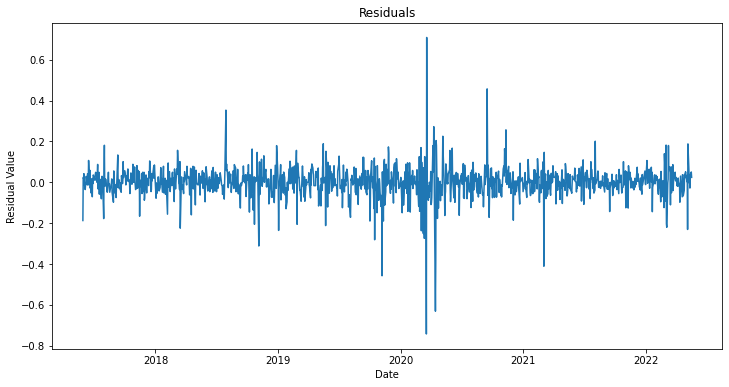

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3569.800, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-238.611, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2187.610, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3567.801, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-240.884, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-241.107, Time=0.21 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-240.151, Time=0.34 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-239.452, Time=0.98 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-239.729, Time=0.73 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-249.317, Time=1.31 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-252.300, Time=1.92 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-252.558, Time=1.52 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-239.737, Time=0.72 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-252.267, Time=1.61 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

                               SARIMAX Results                                
Dep. Variable:                  DLG.L   No. Observations:                 1256
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 131.249
Date:                Mon, 30 Oct 2023   AIC                           -248.498
Time:                        15:25:08   BIC                           -212.548
Sample:                             0   HQIC                          -234.987
                               - 1256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3503      0.523     -0.670      0.503      -1.375       0.674
ar.L1         -0.5292      0.076     -6.969      0.000      -0.678      -0.380
ar.L2          0.7341      0.047     15.646      0.0

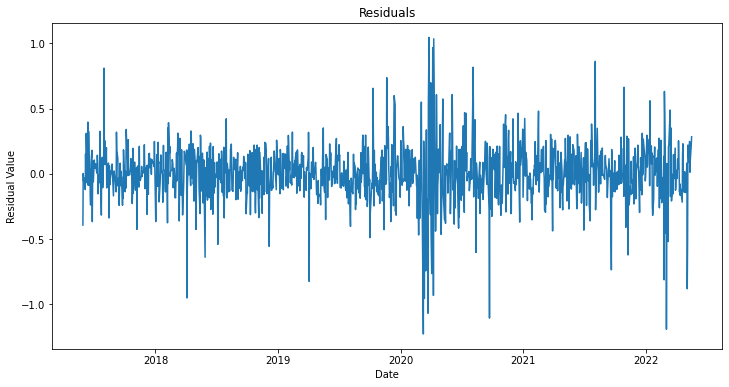

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2751.814, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2752.880, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2752.548, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2752.253, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2754.974, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2757.594, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-2756.352, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2757.141, Time=1.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2756.762, Time=0.79 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-2755.266, Time=1.22 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2758.220, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2755.437, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-2756.914, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-2757.725, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  EMG.L   No. Observations:                 1257
Model:                 ARIMA(3, 1, 0)   Log Likelihood                1383.110
Date:                Mon, 30 Oct 2023   AIC                          -2758.220
Time:                        15:25:14   BIC                          -2737.677
Sample:                             0   HQIC                         -2750.499
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0489      0.020     -2.474      0.013      -0.088      -0.010
ar.L2          0.0613      0.021      2.908      0.004       0.020       0.103
ar.L3          0.0619      0.020      3.043      0.0

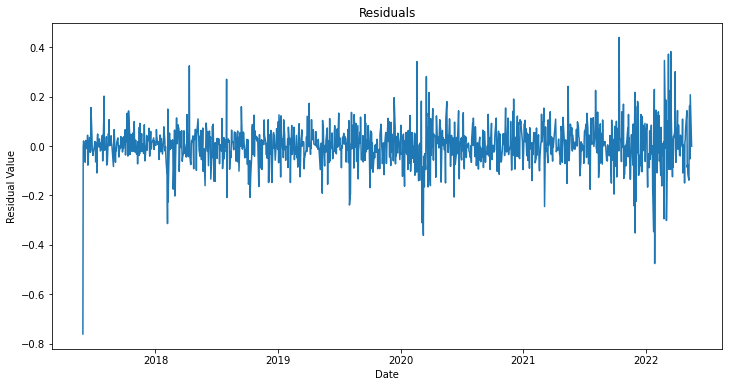

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3688.400, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3686.407, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3686.407, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3689.358, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3684.404, Time=0.54 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.120 seconds
                               SARIMAX Results                                
Dep. Variable:                 DPLM.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1845.679
Date:                Mon, 30 Oct 2023   AIC                          -3689.358
Time:                        15:25:16   BIC                          -3684.222
Sample:                             0   HQIC                         -3687.428
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


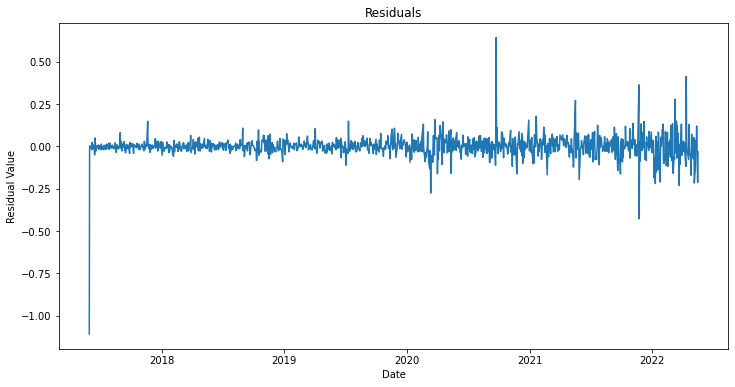

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2742.334, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2745.164, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2745.410, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2743.681, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2744.772, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2744.166, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2742.787, Time=1.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2746.671, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2745.960, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2745.387, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2746.433, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2743.963, Time=0.37 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.195 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


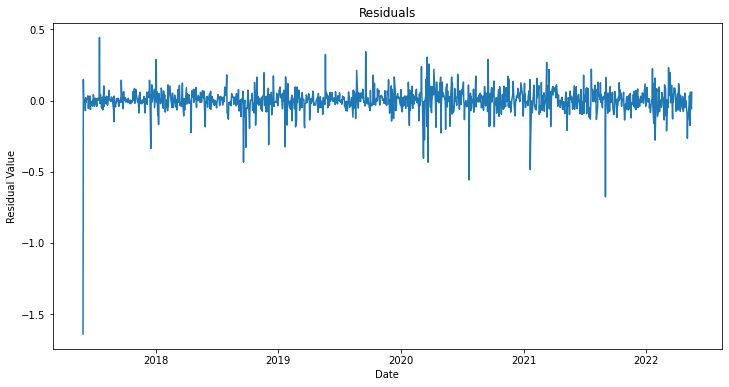

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1477.422, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1475.946, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1475.917, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1479.378, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1474.292, Time=0.42 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.879 seconds
                               SARIMAX Results                                
Dep. Variable:                 WIZZ.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 740.689
Date:                Mon, 30 Oct 2023   AIC                          -1479.378
Time:                        15:25:20   BIC                          -1474.243
Sample:                             0   HQIC                         -1477.448
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


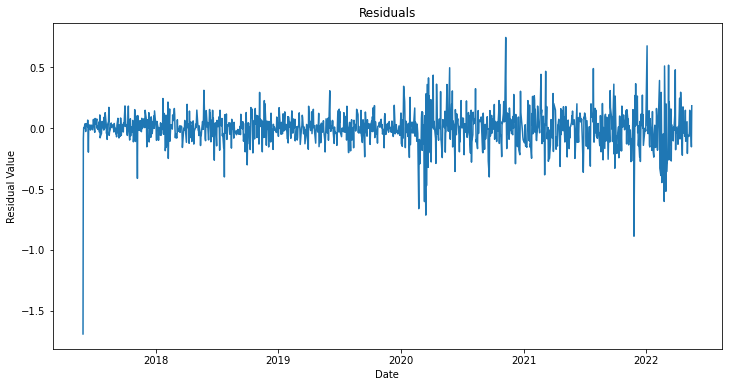

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3133.173, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3131.436, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3131.433, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3133.970, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3129.490, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.516 seconds
                               SARIMAX Results                                
Dep. Variable:                 FRAS.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1567.985
Date:                Mon, 30 Oct 2023   AIC                          -3133.970
Time:                        15:25:21   BIC                          -3128.834
Sample:                             0   HQIC                         -3132.040
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


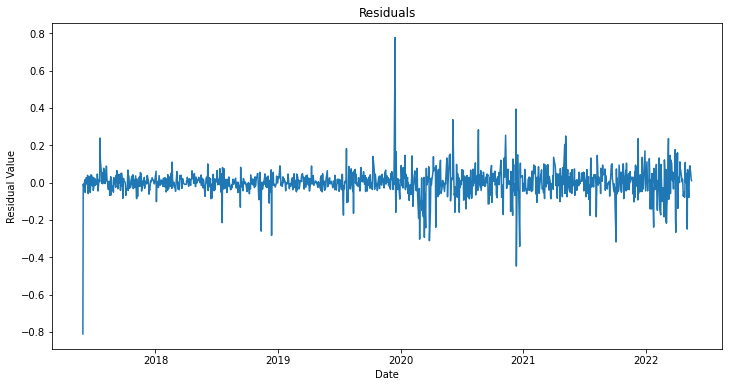

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1704.631, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1702.676, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1702.675, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1706.362, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1700.634, Time=0.53 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.024 seconds
                               SARIMAX Results                                
Dep. Variable:                 TATE.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 854.181
Date:                Mon, 30 Oct 2023   AIC                          -1706.362
Time:                        15:25:23   BIC                          -1701.226
Sample:                             0   HQIC                         -1704.432
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


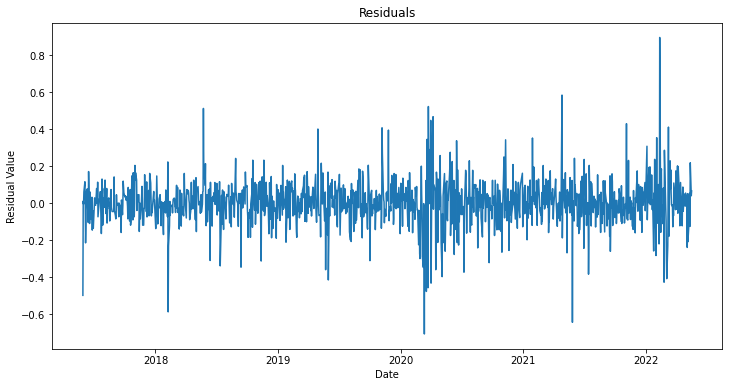

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1979.942, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1979.766, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1979.777, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1981.916, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1977.773, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.476 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  BEZ.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 991.958
Date:                Mon, 30 Oct 2023   AIC                          -1981.916
Time:                        15:25:23   BIC                          -1976.780
Sample:                             0   HQIC                         -1979.986
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0121      0.000     49.291      0.000       0.012       0.013
Ljung-Box (L1) (Q):                   1.83   Jarque-Bera (JB):              1731.49
Prob(Q):                              0.18   Pr

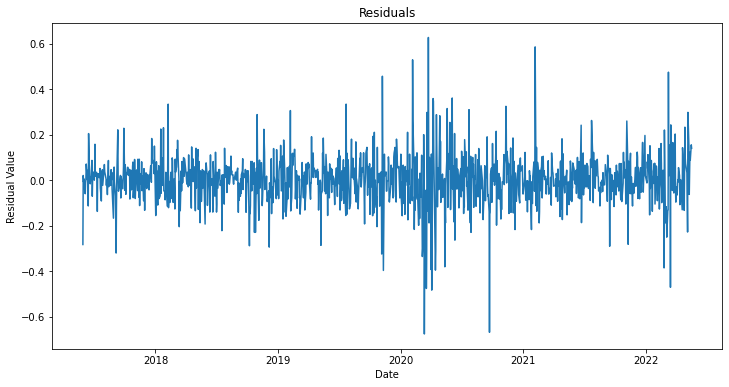

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2755.176, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2754.068, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2754.165, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2757.078, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2766.586, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2768.370, Time=0.91 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2754.966, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2769.454, Time=1.32 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2756.763, Time=0.28 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-2772.256, Time=1.89 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-2765.327, Time=0.30 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-2753.954, Time=1.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2764.609, Time=1.39 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-2774.060, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  PNN.L   No. Observations:                 1257
Model:                 ARIMA(4, 1, 1)   Log Likelihood                1393.030
Date:                Mon, 30 Oct 2023   AIC                          -2774.060
Time:                        15:25:36   BIC                          -2743.246
Sample:                             0   HQIC                         -2762.479
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5128      0.119      4.323      0.000       0.280       0.745
ar.L2         -0.0379      0.023     -1.657      0.098      -0.083       0.007
ar.L3         -0.0310      0.022     -1.417      0.1

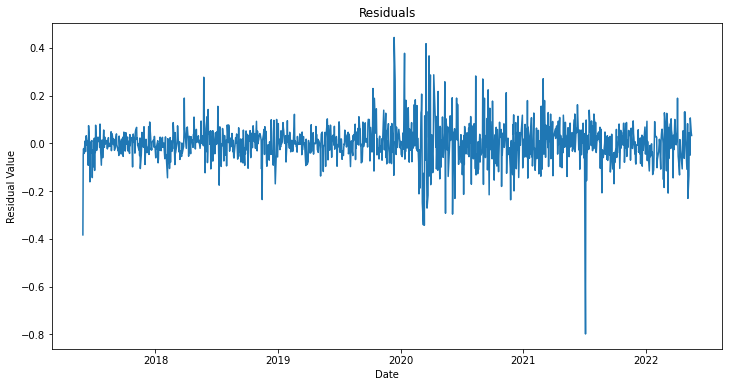

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1436.968, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1435.053, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1435.059, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1438.954, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1436.644, Time=0.72 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.448 seconds
                               SARIMAX Results                                
Dep. Variable:                  RSW.L   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 720.477
Date:                Mon, 30 Oct 2023   AIC                          -1438.954
Time:                        15:25:38   BIC                          -1433.818
Sample:                             0   HQIC                         -1437.024
                               - 1257                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


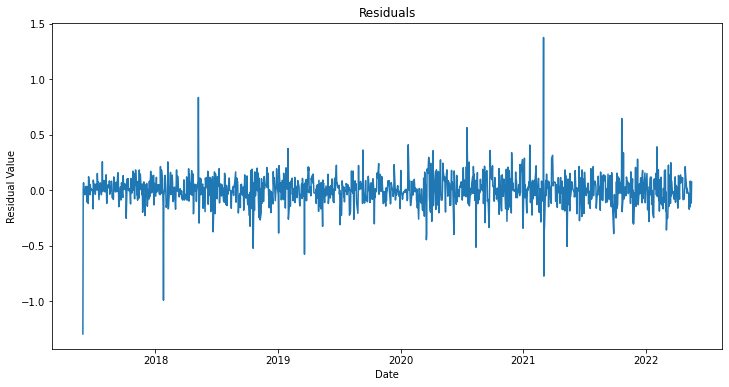

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [15]:
look_forward = 3
dict_df = get_ARIMA_PRED(df_standardised, look_forward)

In [16]:
dict_df_T = dict_df.T
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction
ICP.L,0.0,0.0,1.0,0.333014
ABDN.L,0.0,0.0,1.0,-1.298340
SMDS.L,0.0,0.0,1.0,-0.837839
HL.L,0.0,0.0,1.0,-2.650537
DPH.L,0.0,0.0,1.0,0.368859
HIK.L,0.0,0.0,1.0,-0.211079
HWDN.L,0.0,0.0,1.0,0.672761
IDS.L,2.0,0.0,1.0,0.248436
ITV.L,0.0,0.0,1.0,-1.579369
CCL.L,1.0,0.0,1.0,-1.240304


In [17]:
###############################


#PRODUCE NAIVE PREDICTION
naive_predictions = []
for column in df_standardised.columns:
    naive_predictions.append(df_standardised[column].iloc[-4])
dict_df_T["naive_prediction"] = naive_predictions


In [18]:
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction
ICP.L,0.0,0.0,1.0,0.333014,0.333014
ABDN.L,0.0,0.0,1.0,-1.298340,-1.298340
SMDS.L,0.0,0.0,1.0,-0.837839,-0.837839
HL.L,0.0,0.0,1.0,-2.650537,-2.650537
DPH.L,0.0,0.0,1.0,0.368859,0.368859
HIK.L,0.0,0.0,1.0,-0.211079,-0.211079
HWDN.L,0.0,0.0,1.0,0.672761,0.672761
IDS.L,2.0,0.0,1.0,0.248436,0.242098
ITV.L,0.0,0.0,1.0,-1.579369,-1.579369
CCL.L,1.0,0.0,1.0,-1.240304,-1.240984


In [19]:
#verifying that the naive prediction is identical with the actual price.iloc[-4]
#logic check
df_standardised.iloc[-4] == dict_df_T["naive_prediction"]

Ticker_Symbol
ICP.L     True
ABDN.L    True
SMDS.L    True
HL.L      True
DPH.L     True
HIK.L     True
HWDN.L    True
IDS.L     True
ITV.L     True
CCL.L     True
INVP.L    True
CNA.L     True
CTEC.L    True
UTG.L     True
JMAT.L    True
WEIR.L    True
BBOX.L    True
EZJ.L     True
IMI.L     True
DLN.L     True
TUI.L     True
SXS.L     True
HSX.L     True
DLG.L     True
EMG.L     True
DPLM.L    True
IGG.L     True
WIZZ.L    True
FRAS.L    True
TATE.L    True
BEZ.L     True
PNN.L     True
RSW.L     True
dtype: bool

In [20]:
#logic check
dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]

ICP.L      True
ABDN.L     True
SMDS.L     True
HL.L       True
DPH.L      True
HIK.L      True
HWDN.L     True
IDS.L     False
ITV.L      True
CCL.L     False
INVP.L    False
CNA.L     False
CTEC.L    False
UTG.L      True
JMAT.L     True
WEIR.L    False
BBOX.L     True
EZJ.L     False
IMI.L      True
DLN.L      True
TUI.L     False
SXS.L     False
HSX.L      True
DLG.L     False
EMG.L     False
DPLM.L     True
IGG.L     False
WIZZ.L     True
FRAS.L     True
TATE.L     True
BEZ.L      True
PNN.L     False
RSW.L      True
dtype: bool

In [21]:
(dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]).value_counts()

True     20
False    13
Name: count, dtype: int64

In [22]:
param_df = dict_df_T[dict_df_T["ARIMA_prediction"] != dict_df_T["naive_prediction"]]
param_df #param_df shows us the parameters that gave different ARIMA and Naive predictions

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction
IDS.L,2.0,0.0,1.0,0.248436,0.242098
CCL.L,1.0,0.0,1.0,-1.240304,-1.240984
INVP.L,2.0,1.0,1.0,2.084512,2.048257
CNA.L,0.0,0.0,1.0,0.095821,0.095821
CTEC.L,1.0,1.0,0.0,0.908440,0.917257
WEIR.L,0.0,0.0,1.0,-0.218352,-0.218352
EZJ.L,0.0,0.0,1.0,-1.550766,-1.550766
TUI.L,0.0,1.0,1.0,-1.172306,-1.173271
SXS.L,1.0,0.0,1.0,0.863172,0.869385
DLG.L,3.0,2.0,0.0,-0.218777,-0.199931


In [23]:
#create a new dataframe for comparison of analysis

comparision_df = pd.DataFrame(index = param_df.index)

In [24]:
#file["Actual Price"].index = dict_df_T.index.to_list()
comparision_df["ARIMA_prediction"]=param_df["ARIMA_prediction"]
comparision_df["naive_prediction"]=param_df["naive_prediction"]

comparision_df["Actual Price, y"] =\
(
        actual_price_df.loc[comparision_df.index].values
)


In [25]:
comparision_df

,ARIMA_prediction,naive_prediction
IDS.L,0.248436,0.242098
CCL.L,-1.240304,-1.240984
INVP.L,2.084496,2.048257
CTEC.L,0.908447,0.917257
EZJ.L,-1.550766,-1.550766
TUI.L,-1.172306,-1.173271
SXS.L,0.863172,0.869385
DLG.L,-0.223540,-0.199931
EMG.L,2.838849,2.817487
IGG.L,0.677930,0.681756


In [25]:
comparision_df["Actual Price, y"] = actual_price_df.loc[comparision_df.index].values 
comparision_df

,ARIMA_prediction,naive_prediction,"Actual Price, y"
IDS.L,0.248436,0.242098,0.113929
CCL.L,-1.240304,-1.240984,-1.285805
INVP.L,2.084512,2.048257,2.224992
CNA.L,0.095821,0.095821,-0.125951
CTEC.L,0.908440,0.917257,0.827284
WEIR.L,-0.218352,-0.218352,0.163687
EZJ.L,-1.550766,-1.550766,-1.444282
TUI.L,-1.172306,-1.173271,-1.283375
SXS.L,0.863172,0.869385,0.948598
DLG.L,-0.218777,-0.199931,0.030862


In [26]:
comparision_df["SE_ARIMA"] =\
(
    np.square(comparision_df["ARIMA_prediction"].values - comparision_df["Actual Price, y"].values) 
)

comparision_df["SE_naive"] =\
(
    np.square(comparision_df["naive_prediction"].values - actual_price_df["actual_price"].loc[param_df.index].values)
)
comparision_df.head(3)

#comparision_df shows us where the squared error of deviation between model and actual

,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
IDS.L,0.248436,0.242098,0.113929,0.018092,0.016427
CCL.L,-1.240304,-1.240984,-1.285805,0.002070,0.002009
INVP.L,2.084512,2.048257,2.224992,0.019735,0.031235


In [27]:
dict_df_T["Actual Price, y"] = actual_price_df.loc[dict_df_T.index].values
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y"
ICP.L,0.0,0.0,1.0,0.333014,0.333014,0.625677
ABDN.L,0.0,0.0,1.0,-1.298340,-1.298340,-1.163153
SMDS.L,0.0,0.0,1.0,-0.837839,-0.837839,-0.811039
HL.L,0.0,0.0,1.0,-2.650537,-2.650537,-2.770210
DPH.L,0.0,0.0,1.0,0.368859,0.368859,0.709636
HIK.L,0.0,0.0,1.0,-0.211079,-0.211079,-0.250439
HWDN.L,0.0,0.0,1.0,0.672761,0.672761,0.692900
IDS.L,2.0,0.0,1.0,0.248436,0.242098,0.113929
ITV.L,0.0,0.0,1.0,-1.579369,-1.579369,-1.675253
CCL.L,1.0,0.0,1.0,-1.240304,-1.240984,-1.285805


In [28]:
dict_df_T["SE_ARIMA"] =\
(
    np.square(dict_df_T["ARIMA_prediction"].values - dict_df_T["Actual Price, y"].values) 
)

dict_df_T["SE_naive"] =\
(
    np.square(dict_df_T["naive_prediction"].values - dict_df_T["Actual Price, y"].values)
)
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
ICP.L,0.0,0.0,1.0,0.333014,0.333014,0.625677,0.085652,0.085652
ABDN.L,0.0,0.0,1.0,-1.298340,-1.298340,-1.163153,0.018276,0.018276
SMDS.L,0.0,0.0,1.0,-0.837839,-0.837839,-0.811039,0.000718,0.000718
HL.L,0.0,0.0,1.0,-2.650537,-2.650537,-2.770210,0.014322,0.014322
DPH.L,0.0,0.0,1.0,0.368859,0.368859,0.709636,0.116129,0.116129
HIK.L,0.0,0.0,1.0,-0.211079,-0.211079,-0.250439,0.001549,0.001549
HWDN.L,0.0,0.0,1.0,0.672761,0.672761,0.692900,0.000406,0.000406
IDS.L,2.0,0.0,1.0,0.248436,0.242098,0.113929,0.018092,0.016427
ITV.L,0.0,0.0,1.0,-1.579369,-1.579369,-1.675253,0.009194,0.009194
CCL.L,1.0,0.0,1.0,-1.240304,-1.240984,-1.285805,0.002070,0.002009


In [29]:
#market share extraction. market share on rank date strictly

tickers = symbols_short

def extract_sp(stocks, start, end):
    def data(ticker):
        return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
    FAANG_Stock = map(data, stocks)
    return(pd.concat(FAANG_Stock,
                     keys = stocks,
                     names = ["Company", "Date"]
                    )
          )


result_ = extract_sp(tickers,start="2023-05-30", end="2023-05-31")
result_df = pd.DataFrame(result_, columns = ['Market Share'])
market_share_df_strict =\
(
    result_df
    .reset_index()
    .sort_values(by='Date', ascending = False)
    .drop_duplicates(subset='Company', keep='last')

)

market_share_df_strict

,Company,Date,Market Share
0,ICP.L,2023-05-31 00:00:00+01:00,290600992
1,ABDN.L,2023-05-31 00:00:00+01:00,2001890048
22,BEZ.L,2023-05-31 00:00:00+01:00,672235008
21,FRAS.L,2023-05-31 00:00:00+01:00,467475008
20,IGG.L,2023-05-31 00:00:00+01:00,408948000
19,HSX.L,2023-05-31 00:00:00+01:00,346553984
18,SXS.L,2023-05-31 00:00:00+01:00,104612000
17,TUI.L,2023-05-31 00:00:00+01:00,347913984
16,DLN.L,2023-05-31 00:00:00+01:00,112291000
15,EZJ.L,2023-05-31 00:00:00+01:00,758000000


In [30]:
### market share NEAR rank date

def extract_sp(stocks, start, end):
    def data(ticker):
        return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
    FAANG_Stock = map(data, stocks)
    return(pd.concat(FAANG_Stock,
                     keys = stocks,
                     names = ["Company", "Date"]
                    )
          )

#tickers = ['AAPL','MSFT']

tickers = symbols_short

result_ = extract_sp(tickers,start="2015-05-23", end="2023-05-31")
result_df = pd.DataFrame(result_, columns = ['Market Share'])
market_share_df =\
(
    result_df
    .reset_index()
    .sort_values(by='Date', ascending = False)
    .drop_duplicates(subset='Company', keep='first')

)

market_share_df

,Company,Date,Market Share
4125,CTEC.L,2023-05-31 00:00:00+01:00,2045590016
3847,CNA.L,2023-05-31 00:00:00+01:00,5641390080
3175,CCL.L,2023-05-31 00:00:00+01:00,1302819968
2285,HWDN.L,2023-05-31 00:00:00+01:00,550238016
4739,JMAT.L,2023-05-31 00:00:00+01:00,183452992
7205,TUI.L,2023-05-31 00:00:00+01:00,347913984
11445,BEZ.L,2023-05-31 00:00:00+01:00,672235008
319,ICP.L,2023-05-31 00:00:00+01:00,290600992
4442,UTG.L,2023-05-31 00:00:00+01:00,402523008
3477,INVP.L,2023-05-31 00:00:00+01:00,653596992


In [31]:
#checking for stock that doesnt have market share extracted


dict_df_T.index[~dict_df_T.index.isin(market_share_df["Company"].to_list())]

Index([], dtype='object')

In [32]:
market_share_df_ = market_share_df.set_index("Company")
ordered_market_share_df = market_share_df_.loc[dict_df_T.index]
ordered_market_share_df

,Date,Market Share
ICP.L,2023-05-31 00:00:00+01:00,290600992
ABDN.L,2023-05-31 00:00:00+01:00,2001890048
SMDS.L,2023-05-19 00:00:00+01:00,1377449984
HL.L,2023-05-30 00:00:00+01:00,474319008
DPH.L,2023-05-27 00:00:00+01:00,113884000
HIK.L,2023-05-31 00:00:00+01:00,220988000
HWDN.L,2023-05-31 00:00:00+01:00,550238016
IDS.L,2023-05-27 00:00:00+01:00,956193024
ITV.L,2023-05-31 00:00:00+01:00,4034409984
CCL.L,2023-05-31 00:00:00+01:00,1302819968


In [33]:
len(ordered_market_share_df)

33

In [34]:
#confusion matrix

#define positive, with reference to the rank of the 35 stocks at balancing date.
#need to multiply the actual price(un-normalised) * number of outstanding share
#postive result is reflected as 1 when the market cap of the 35 stocks are above the lowest of the 100th market cap. 

#un-normalise the actual_price
ticker_mean_df = pd.Series(ticker_mean_dict.values(), index = ticker_mean_dict.keys())
ticker_std_df = pd.Series(ticker_std_dict.values(), index = ticker_std_dict.keys())

dict_df_T["un-normalised_actual_mrkt_share"] = pd.Series((actual_price_df.values.flatten() * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_ARIMA_pred_mrkt_share"] = pd.Series((dict_df_T["ARIMA_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_naive_pred_mrkt_share"] = pd.Series((dict_df_T["naive_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
result = dict_df_T[["un-normalised_actual_mrkt_share", "un-normalised_ARIMA_pred_mrkt_share", "un-normalised_naive_pred_mrkt_share"]].mul(ordered_market_share_df["Market Share"], axis=0)
result

#np.dot(actual_price_df.T, ticker_std_df) + ticker_mean_df

#dict_df_T["Actual_price_un-normoralised"] = pd.DataFrame(np.dot(actual_price_df.T, ticker_mean_df).T)

,un-normalised_actual_mrkt_share,un-normalised_ARIMA_pred_mrkt_share,un-normalised_naive_pred_mrkt_share
ICP.L,4.255120e+11,3.901808e+11,3.901808e+11
ABDN.L,3.511382e+11,3.394377e+11,3.394377e+11
SMDS.L,3.896211e+11,3.878317e+11,3.878317e+11
HL.L,3.908964e+11,4.051417e+11,4.051417e+11
DPH.L,4.062938e+11,3.716836e+11,3.716836e+11
HIK.L,3.625591e+11,3.666638e+11,3.666638e+11
HWDN.L,3.607606e+11,3.590251e+11,3.590251e+11
IDS.L,2.999584e+11,3.141968e+11,3.135259e+11
ITV.L,2.593150e+11,2.674365e+11,2.674365e+11
CCL.L,1.317802e+12,1.400086e+12,1.398858e+12


In [35]:
symbols['Ticker'] = symbols['Ticker'].str.split(' ').str[0]
symbols['Ticker'] = symbols['Ticker'] + ".L"
symbols.head(3)

,Ticker,Name,Weight,Shares,Price,Market Cap,SEDOL,ISIN,Index,Ticker_Symbol
0,ICP.L,Intermediate Capital Group PLC,0.206840,277.817407,1457.50,4234802176,BYT1DJ1,GB00BYT1DJ19,FTSE100,ICP.L
1,ABDN.L,abrdn plc,0.208414,2146.807357,190.05,4144469248,BF8Q6K6,GB00BF8Q6K64,FTSE100,ABDN.L
2,SMDS.L,DS Smith PLC,0.194905,1274.820668,299.30,4118135808,0822011,GB0008220112,FTSE100,SMDS.L


In [36]:
#data is the prediction result
result2 = result.reset_index().rename(columns = {"index": "Ticker"})
merged = result2.merge(symbols, how='left', on='Ticker') #target universe is list before rank date


In [37]:
merged.head(3)

,Ticker,un-normalised_actual_mrkt_share,un-normalised_ARIMA_pred_mrkt_share,un-normalised_naive_pred_mrkt_share,Name,Weight,Shares,Price,Market Cap,SEDOL,ISIN,Index,Ticker_Symbol
0,ICP.L,4.255120e+11,3.901808e+11,3.901808e+11,Intermediate Capital Group PLC,0.206840,277.817407,1457.50,4234802176,BYT1DJ1,GB00BYT1DJ19,FTSE100,ICP.L
1,ABDN.L,3.511382e+11,3.394377e+11,3.394377e+11,abrdn plc,0.208414,2146.807357,190.05,4144469248,BF8Q6K6,GB00BF8Q6K64,FTSE100,ABDN.L
2,SMDS.L,3.896211e+11,3.878317e+11,3.878317e+11,DS Smith PLC,0.194905,1274.820668,299.30,4118135808,0822011,GB0008220112,FTSE100,SMDS.L


## 90percentile decision module + confusion matrix 

In [40]:
#this is the decision module
def get_top10(merged_df, column):
    merged_df2 = merged_df.sort_values(by=column, ascending = False).reset_index(drop=True)
    ftse_250 = merged_df2[merged_df2["Index"] =='FTSE250']
    ftse_100 = merged_df2[merged_df2["Index"] =='FTSE100']

    # list of stocks that is going into FTSE100
    stocks_into_FTSE100 = ftse_250[ftse_250.index<ftse_100.index[0]]['Ticker'].to_list()

    # number of stocks that is going into FTSE100
    number_of_stocks = len(stocks_into_FTSE100)

    # list of stocks that is going out from FTSE100
    stocks_out_from_FTSE100 = ftse_100['Ticker'].tail(number_of_stocks).to_list()
    
    return stocks_into_FTSE100, stocks_out_from_FTSE100

stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive = get_top10(merged, "un-normalised_naive_pred_mrkt_share")
stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA = get_top10(merged, "un-normalised_ARIMA_pred_mrkt_share")

def confusion_matrix(stocks_into_FTSE100, stocks_out_from_FTSE100):
    post_rebalancing = pd.read_csv("ftse100_rebalancing_summary.csv")
    post_rebalancing['Ticker'] = post_rebalancing['Ticker'].str.split(' ').str[0]
    post_rebalancing['Ticker'] = post_rebalancing['Ticker'] + ".L"

    true_positive_100 =\
    (
        post_rebalancing[post_rebalancing["FTSE100"] == -1.0]["Ticker"]
    )
    true_negative_100 =\
    (
        post_rebalancing[post_rebalancing["FTSE100"] == 1.0]["Ticker"]
    )
#     true_positive_250 =\
#     (
#         post_rebalancing[post_rebalancing["FTSE250"] == 1.0]["Ticker"]
#     )
#     true_negative_250 =\
#     (
#         post_rebalancing[post_rebalancing["FTSE250"] == -1.0]["Ticker"]
#     )
    
    true_positive_count = 0
    true_negative_count = 0
    
    for outgoing in stocks_out_from_FTSE100:
        if true_positive_100.isin([outgoing]).any():
            true_positive_count+=1
    
    for incoming in stocks_into_FTSE100:
        if true_negative_100.isin([incoming]).any():
            true_negative_count+=1
            
    #reconfirm the top10 predicted
    going_up_length = len(stocks_into_FTSE100)

    retained_in_top10 = list(symbols["Ticker"].iloc[:10 - going_up_length].values)
    retained_in_top10.extend(stocks_into_FTSE100)

    #reconfirm the bottom 25 predicted
    coming_down_length = len(stocks_out_from_FTSE100)

    retained_in_bottom25 = list(symbols["Ticker"].iloc[(10 + coming_down_length):].values)
    retained_in_bottom25.extend(stocks_into_FTSE100)
    
    true_positive = true_positive_count / len(retained_in_top10 + retained_in_bottom25)
    false_positive = (len(retained_in_top10)-true_positive_count) / len(retained_in_top10 + retained_in_bottom25)
    true_negative = true_negative_count / len(retained_in_top10 + retained_in_bottom25)
    false_negative = (len(retained_in_bottom25)-true_negative_count) / len(retained_in_top10 + retained_in_bottom25)
    
    #can return retained_in_top10 and retained_in_bottom25 to know the ordered prediction of top10&bottom25 if we want
    return true_positive, false_positive, true_negative, false_negative
    

In [44]:
true_positive_naive, false_positive_naive, true_negative_naive, false_negative_naive = confusion_matrix(stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive)
true_positive_ARIMA, false_positive_ARIMA, true_negative_ARIMA, false_negative_ARIMA = confusion_matrix(stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA)


In [45]:
#logic check, must sum to 1
sum(confusion_matrix(stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive))

1.0

In [46]:
#logic check, must sum to 1
sum(confusion_matrix(stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA))

1.0

In [48]:
print("Percentage of true positive in naive model is {:.3f}%".format(true_positive_naive*100))
print("Percentage of true negative in naive model is {:.3f}%".format(true_negative_naive*100))
print("Percentage of false positive in naive model is {:.3f}%".format(false_positive_naive*100))
print("Percentage of false negative in naive model is {:.3f}%".format(false_negative_naive*100))

Percentage of true positive in naive model is 15.152%
Percentage of true negative in naive model is 9.091%
Percentage of false positive in naive model is 15.152%
Percentage of false negative in naive model is 60.606%


In [49]:
print("Percentage of true positive in ARIMA model is {:.3f}%".format(true_positive_ARIMA*100))
print("Percentage of true negative in ARIMA model is {:.3f}%".format(true_negative_ARIMA*100))
print("Percentage of false positive in ARIMA model is {:.3f}%".format(false_positive_ARIMA*100))
print("Percentage of false negative in ARIMA model is {:.3f}%".format(false_negative_ARIMA*100))

Percentage of true positive in ARIMA model is 15.152%
Percentage of true negative in ARIMA model is 9.091%
Percentage of false positive in ARIMA model is 15.152%
Percentage of false negative in ARIMA model is 60.606%


In [ ]:
#same false positive between ARIMA and NAIVE.

In [ ]:
#param_df shows us the parameters that gave different ARIMA and Naive predictions